In [1]:
%load_ext pep8magic
%matplotlib inline
# standard
import csv
import glob
import json
import os
import re
import time
# 3rd-party
import matplotlib.pyplot as plt
import pandas as pd
import pytablewriter
import requests_oauthlib
from scipy import stats
# self-made
from conf import *

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


In [2]:
"""
read raw csv
file is obtained by Twitter Media Downloader
https://memo.furyutei.work/entry/20160723/1469282864
"""
# read the latest file in the csv folder
dir = sorted(glob.glob('./CSV/*/'))[-1]
file = glob.glob(dir+'*dryrun.csv')[0]
c_d = pd.read_csv(file,
                  parse_dates=['Tweet date'],
                  skiprows=[0, 1, 2, 3])
c_d

,Tweet date,Action date,Display name,Username,Tweet URL,Media type,Media URL,Saved filename,Remarks,Tweet content,Replies,Retweets,Likes
0,2020-02-20 19:03:38,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12304...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人＿\n＞ 私もロゴが欲しい！ ＜\n￣Y^Y^Y^Y^Y^Y^Y^Y...,NaN,2.0,1.0
1,2020-02-20 14:24:29,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,【チョコレートケーキ】 本日下記の時間でわかめとオクラのサラダ(Lサイズ)を行います！ ミニ...,NaN,1.0,1.0
2,2020-02-20 14:22:20,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,【イカの墨入りスパゲッティ(Wサイズ)】https://twitter.com/delvi5...,NaN,NaN,1.0
3,2020-02-20 10:47:50,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,GIF,https://video.twimg.com/tweet_video/ERLupO_UEA...,minyoruminyon-1230308042555527168-20200220_104...,NaN,https://twitter.com/nishi_shio/status/12303079...,NaN,1.0,6.0
4,2020-02-20 10:44:16,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,અⷬનͥનⷫાͤસͣ https://twitter.com/k1a030371/statu...,NaN,NaN,NaN
5,2020-02-20 10:43:22,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,cͣrⷫoͥsͫsͣiᷝng https://twitter.com/k1a030371/s...,NaN,NaN,1.0
6,2020-02-20 10:35:39,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12303...,No media,NaN,NaN,NaN,西野七瀬https://twitter.com/mrmrdpgavpwmq/status/1...,NaN,1.0,1.0
7,2020-02-20 10:00:24,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12302...,No media,NaN,NaN,NaN,cabins thursday\n#シャイニングマンデー #プレミアムフライデーhttps:...,NaN,NaN,NaN
8,2020-02-20 07:48:12,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12302...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人人人人＿\n＞ スロットで約28万円スった ＜\n￣Y^Y^Y^Y^...,NaN,2.0,4.0
9,2020-02-20 04:31:40,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/12302...,No media,NaN,NaN,NaN,THIS HAS BEEN SEIZED.\nあーあ\n₍₍⁽⁽₎₎⁾⁾\nかわいいね\n...,NaN,1.0,3.0


In [3]:
# fetch tweeted user from tweet link URL by API
"""
statuses/show/:id ツイートid1つから取得
900tweet/15m
(wait: /1req)
処理簡単

statuses/lookup ツイートid100つから取得
30000tweet/15m
処理複雑(そうでもない)
"""


def getUser(url, twitter):
    params = {
        'id': re.search(r'^(\d+)', url[::-1]).groups()[0][::-1],
        'trim_user': 'false',
        'include_my_retweet': 'false',
        'include_entities': 'true',
    }
    while True:
        req = twitter.get('https://api.twitter.com/1.1/statuses/show.json',
                          params=params)
        time.sleep(1)
        if req.status_code == 200:
            j = json.loads(req.text)
            try:
                return j['quoted_status']['user']['screen_name']
            except KeyError:
                """
                estimate from the URL in tweet
                when the quoted tweet has been deleted (Reliability: low)
                """
                urls = [u['expanded_url'] for u in j['entities']['urls']]
                cand = [re.search(r'https://twitter.com/([^/]+)/status/\d+',
                                  u) for u in urls]
                cand = [t.groups(1)[0] for t in cand if t]
                if cand:
                    return cand[0]
                else:
                    return 'minyoruminyon'
        else:
            continue


In [4]:
# make formatted.csv
newcsv = {'Date': c_d['Tweet date'],
          'URL': c_d['Tweet URL'],
          'User': [],
          'R+L': c_d['Retweets'].fillna(0) + c_d['Likes'].fillna(0),
          'Retweets': c_d['Retweets'],
          'Likes': c_d['Likes'],
          'm': c_d['Tweet content']
         }

# estimate one specific user posted a tweet
# which was RT'd by @minyoruminyon
twitter = requests_oauthlib.OAuth1Session(CK, CS, t_AT, AS)
i, cnt, lineno = 0, 0, len(c_d)
for l in [[k, v] for k, v in zip(newcsv['URL'], newcsv['m'])]:
    i += 1
    user = re.findall(
        r'https://twitter.com/([a-zA-Z0-9_]+)/status/[0-9]+',
        l[1])
    user = list(set(user)-set(['minyoruminyon']))
    print("%05d/%d:%s..." % (i, lineno, str(user)[0:35]),
          " " * 50, end="\r")
    if not user:
        user = 'minyoruminyon'
    else:
        if user == ['minyoruminyon']:
            user = 'minyoruminyon'
        elif len(user) == 1:
            user = user[0]
        else:
            user = getUser(l[0], twitter)
            cnt += 1
            time.sleep(1)
    newcsv['User'].append(user)
print("Process Ended.(about: %ds, line: %d)" %(cnt + 1, lineno))
newcsv.pop('m')
pd.DataFrame(newcsv).fillna(0).to_csv(dir+'formatted.csv', index=None)
pd.read_csv(dir + 'formatted.csv')

,Date,URL,User,R+L,Retweets,Likes
0,2020-02-20 19:03:38,https://twitter.com/minyoruminyon/status/12304...,blacknon_,3.0,2.0,1.0
1,2020-02-20 14:24:29,https://twitter.com/minyoruminyon/status/12303...,delvi511,2.0,1.0,1.0
2,2020-02-20 14:22:20,https://twitter.com/minyoruminyon/status/12303...,delvi511,1.0,0.0,1.0
3,2020-02-20 10:47:50,https://twitter.com/minyoruminyon/status/12303...,nishi_shio,7.0,1.0,6.0
4,2020-02-20 10:44:16,https://twitter.com/minyoruminyon/status/12303...,k1a030371,0.0,0.0,0.0
5,2020-02-20 10:43:22,https://twitter.com/minyoruminyon/status/12303...,k1a030371,1.0,0.0,1.0
6,2020-02-20 10:35:39,https://twitter.com/minyoruminyon/status/12303...,mrmrdpgavpwmq,2.0,1.0,1.0
7,2020-02-20 10:00:24,https://twitter.com/minyoruminyon/status/12302...,RandomWeekday,0.0,0.0,0.0
8,2020-02-20 07:48:12,https://twitter.com/minyoruminyon/status/12302...,nekohachiYS58,6.0,2.0,4.0
9,2020-02-20 04:31:40,https://twitter.com/minyoruminyon/status/12302...,egpl0,4.0,1.0,3.0


In [5]:
# read formatted.csv
f_d = pd.read_csv(dir+'formatted.csv')
# make user.csv
userdata = []
c = 1
tmp = None
for k, v in f_d['User'].value_counts().items():
    userdata.append([c, k, v])
    if tmp != v:
        c += 1
    if not tmp:
        tmp = v
    tmp = v
with open(dir+'user.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Rank', 'User', 'Count'])
    w.writerows(userdata)
pd.read_csv(dir+'user.csv')

,Rank,User,Count
0,1,jiro_saburomaru,4726
1,2,ryuichiueda,4241
2,3,blacknon_,3114
3,4,qwertanus,2287
4,5,yami_buta,2246
5,6,grethlen,1188
6,7,QiToYtkg,1149
7,8,egpl0,968
8,9,ytkmns,856
9,10,eban,724


In [6]:
# make buzz.csv
buzz = f_d.sort_values('R+L', ascending=False)
buzz.to_csv(dir+'buzz.csv', index=None)
# reindex
buzz = pd.read_csv(dir+'buzz.csv')
buzz.index = buzz.index + 1
buzz.to_csv(dir+'buzz.csv')
buzz[0:1000].to_csv(dir+'buzz_1000.csv')
pd.read_csv(dir+'buzz_1000.csv')

,Unnamed: 0,Date,URL,User,R+L,Retweets,Likes
0,1,2020-01-28 09:02:17,https://twitter.com/minyoruminyon/status/12219...,yami_buta,4438.0,1478.0,2960.0
1,2,2019-05-21 22:08:09,https://twitter.com/minyoruminyon/status/11308...,ryuichiueda,2393.0,978.0,1415.0
2,3,2019-06-30 23:15:50,https://twitter.com/minyoruminyon/status/11453...,yami_buta,949.0,301.0,648.0
3,4,2020-01-29 00:55:40,https://twitter.com/minyoruminyon/status/12221...,yami_buta,674.0,232.0,442.0
4,5,2019-07-25 06:50:41,https://twitter.com/minyoruminyon/status/11541...,jiro_saburomaru,597.0,242.0,355.0
5,6,2019-08-29 20:31:53,https://twitter.com/minyoruminyon/status/11670...,yukito_2828,555.0,234.0,321.0
6,7,2019-08-26 23:20:08,https://twitter.com/minyoruminyon/status/11659...,yamaya,393.0,103.0,290.0
7,8,2019-06-01 12:36:18,https://twitter.com/minyoruminyon/status/11346...,ryuichiueda,372.0,133.0,239.0
8,9,2019-02-17 01:09:34,https://twitter.com/minyoruminyon/status/10968...,kazuki_199778,335.0,140.0,195.0
9,10,2019-04-07 02:04:49,https://twitter.com/minyoruminyon/status/11145...,yamaya,327.0,126.0,201.0


In [7]:
# by month
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
bymonth = []
for y in t['Date'].dt.year.unique()[::-1]:
    for m in range(1, 13):
        bymonth.append(["%d/%d" % (y, m),
                       len(t[(t['Date'].dt.year == y) &
                             (t['Date'].dt.month == m)])])
with open(dir+'month.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in bymonth]
pd.read_csv(dir+'month.csv')

,2017/1,0
0,2017/2,0
1,2017/3,0
2,2017/4,0
3,2017/5,0
4,2017/6,622
5,2017/7,571
6,2017/8,325
7,2017/9,279
8,2017/10,302
9,2017/11,181


In [8]:
# by hour
t = pd.read_csv(dir+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
byhour = []
for h in range(0, 24):
    byhour.append(["%02d" % h,
                  len(t[(t['Date'].dt.hour == h)])])
with open(dir+'hour.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in byhour]
pd.read_csv(dir+'hour.csv')

,00,2989
0,1,1712
1,2,961
2,3,557
3,4,426
4,5,362
5,6,607
6,7,1128
7,8,1756
8,9,1961
9,10,2285


In [9]:
# extract some user's one
try:
    os.makedirs(dir+'/user/')
except FileExistsError:
    pass


def extractUser(target):
    n = dir+'/user/%s.csv' % target
    a = pd.read_csv(dir + 'formatted.csv')
    a[(a['User'] == target)].to_csv(n, index=False)
    pd.read_csv(n).to_csv(n)
    return pd.read_csv(n)

u = pd.read_csv(dir + 'user.csv')
for t in u[(u['Count'] > 9)]['User']:
    print(t, '            ', end="\r")
    extractUser(t)
print('========END========')

========END========                      


In [10]:
u = pd.read_csv(dir+'user.csv')
print(len(u),
      len(u[(u['Count'] > 9)]))

1655 505


In [11]:
# make user.md
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(
    u.replace({'User': r'([0-9_a-zA-Z]+)'},
              {'User': r'[\1](https://twitter.com/\1)'}, regex=True))
writer.dump(dir+"user.md")
writer.write_table()

|Rank|                         User                         |Count|
|---:|------------------------------------------------------|----:|
|   1|[jiro_saburomaru](https://twitter.com/jiro_saburomaru)| 4726|
|   2|[ryuichiueda](https://twitter.com/ryuichiueda)        | 4241|
|   3|[blacknon_](https://twitter.com/blacknon_)            | 3114|
|   4|[qwertanus](https://twitter.com/qwertanus)            | 2287|
|   5|[yami_buta](https://twitter.com/yami_buta)            | 2246|
|   6|[grethlen](https://twitter.com/grethlen)              | 1188|
|   7|[QiToYtkg](https://twitter.com/QiToYtkg)              | 1149|
|   8|[egpl0](https://twitter.com/egpl0)                    |  968|
|   9|[ytkmns](https://twitter.com/ytkmns)                  |  856|
|  10|[eban](https://twitter.com/eban)                      |  724|
|  11|[shishimy](https://twitter.com/shishimy)              |  597|
|  12|[kino___ma](https://twitter.com/kino___ma)            |  499|
|  13|[CareleSmith9](https://twitter.com/CareleS

In [12]:
# make buzz.md
writer = pytablewriter.MarkdownTableWriter()
b = pd.read_csv(dir+'buzz.csv').replace(
            {'User':r'([0-9_a-zA-Z]+)'}, 
            {'User':r'[\1](https://twitter.com/\1)'},regex=True
    ).replace(
            {'URL':r'(^.*$)'}, 
            {'URL':r'[\1](\1)'},regex=True
    )
writer.from_dataframe(b)
writer.dump(dir+"buzz.md")
writer.from_dataframe(b[0:1000])
writer.dump(dir+"buzz_1000.md")
writer.from_dataframe(b[0:500])
writer.dump(dir+"buzz_500.md")
writer.from_dataframe(b[0:100])
writer.dump(dir+"buzz_100.md")
writer.write_table()

|Unnamed: 0|       Date        |                                                            URL                                                             |                         User                         |R+L |Retweets|Likes|
|---------:|-------------------|----------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------|---:|-------:|----:|
|         1|2020-01-28 09:02:17|[https://twitter.com/minyoruminyon/status/1221946561506078720](https://twitter.com/minyoruminyon/status/1221946561506078720)|[yami_buta](https://twitter.com/yami_buta)            |4438|    1478| 2960|
|         2|2019-05-21 22:08:09|[https://twitter.com/minyoruminyon/status/1130822587242561536](https://twitter.com/minyoruminyon/status/1130822587242561536)|[ryuichiueda](https://twitter.com/ryuichiueda)        |2393|     978| 1415|
|         3|2019-06-30 23:15:50|[https://twitter.com/minyoruminyon/s

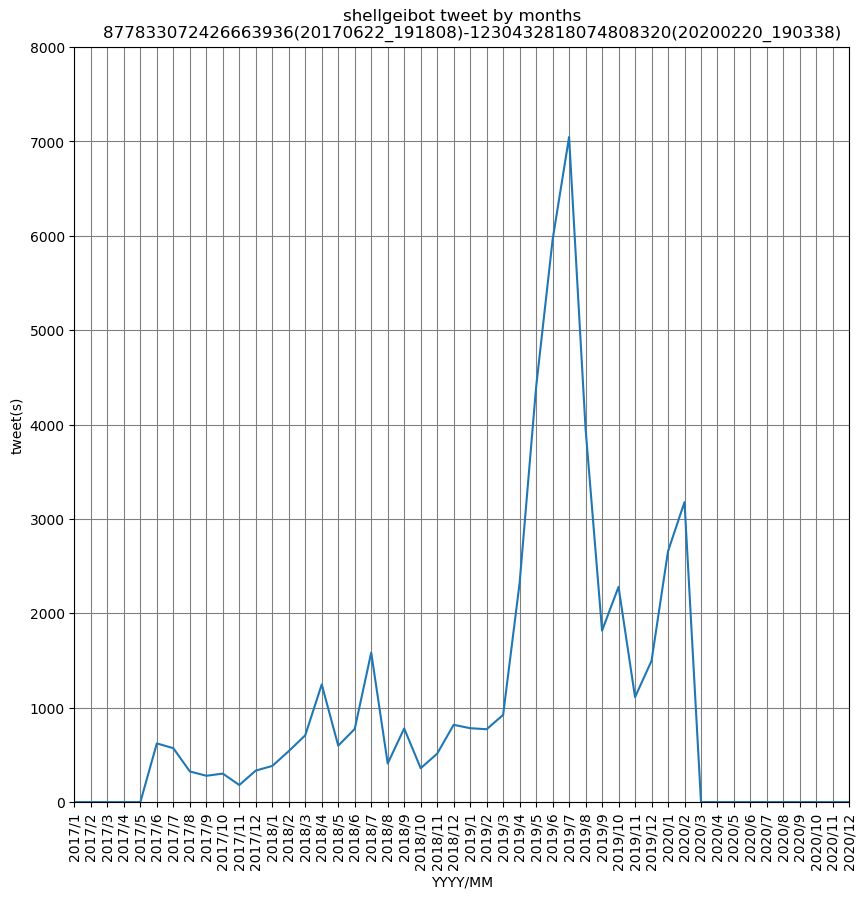

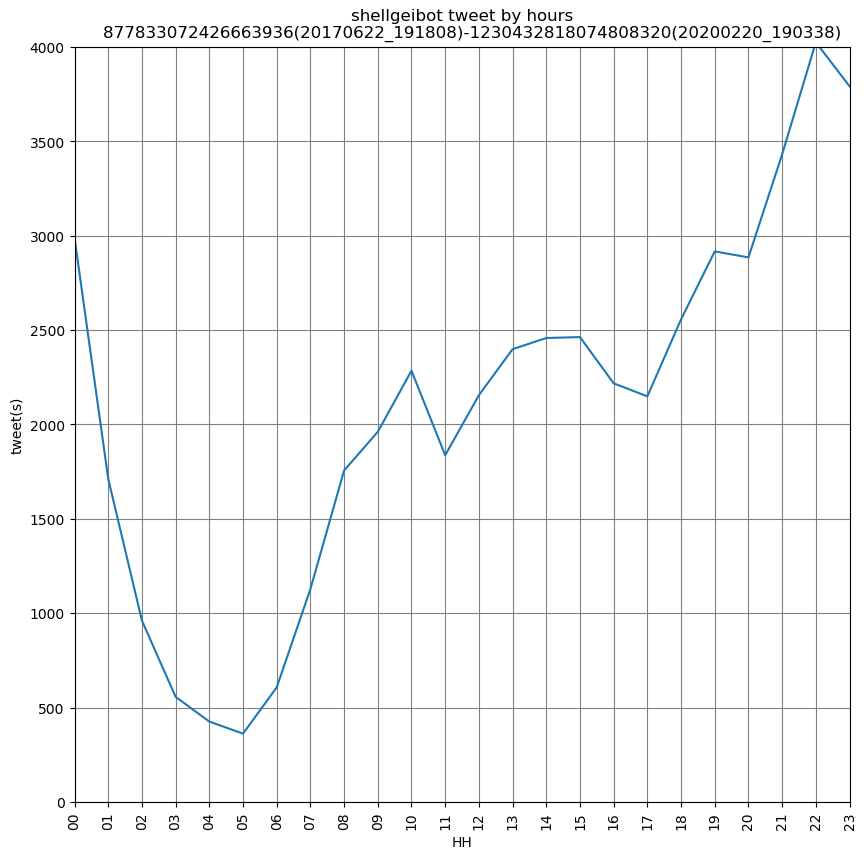

In [13]:
# make graphs
def showgraph(name, title, xlabel, ylim, dir):
    f = [i.split(',') for i in open(name).readlines()]
    x, y = [], []
    for i in f:
        x.append(i[0])
        y.append(int(i[1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.xlim(0, len(x)-1)
    plt.ylim(0, ylim)
    plt.grid(color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('tweet(s)')
    plt.plot(x, y)
    plt.xticks(rotation=90)
    plt.savefig(dir + title + '.png')
showgraph(
    dir+"month.csv",
    """shellgeibot tweet by months
    %s""" % (file[49:][:-11]),
    "YYYY/MM",
    8000,
    dir
)
showgraph(
    dir+"hour.csv",
    """shellgeibot tweet by hours
    %s""" % (file[49:][:-11]),
    "HH",
    4000,
    dir
)